# 資料挖掘作業 2：吸菸預測模型

本專案透過多個機器學習模型的集成方法來預測吸菸狀態。我們使用了三種強大的梯度提升樹模型：XGBoost、LightGBM 和 CatBoost，並透過 Optuna 進行超參數優化，最後根據驗證集上的 AUC 得分進行加權集成。

## 1. 導入所需套件

首先導入所有需要使用的套件和函式庫。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from datetime import datetime
import optuna
import shap
import time
import warnings

warnings.filterwarnings("ignore")
start_time = time.time()

c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. 資料載入與探索

在這個部分，我們載入訓練和測試資料集，並進行初步的資料探索。

In [2]:
# 載入資料集
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# 顯示訓練集的基本資訊
print(f"訓練集形狀: {train.shape}")
print(f"測試集形狀: {test.shape}")
train.head()

訓練集形狀: (15000, 24)
測試集形狀: (10000, 23)


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,25.0,170.0,60.0,75.0,1.5,1.2,1.0,1.0,100.0,...,50.0,81.0,15.2,1.0,0.8,18.0,16.0,19.0,1.0,1.0
1,1,40.0,165.0,65.0,79.0,1.0,1.2,1.0,1.0,130.0,...,58.0,130.0,12.8,1.0,0.6,31.0,26.0,33.0,0.0,0.0
2,2,50.0,170.0,80.0,93.0,1.2,1.0,1.0,1.0,130.0,...,44.0,130.0,16.7,1.0,0.9,38.0,46.0,69.0,0.0,1.0
3,3,75.0,160.0,60.0,89.0,0.8,1.0,1.0,1.0,116.0,...,44.0,149.0,15.1,1.0,1.1,24.0,22.0,20.0,0.0,0.0
4,4,60.0,170.0,75.0,89.0,0.8,0.8,1.0,1.0,138.0,...,38.0,122.0,14.6,1.0,1.0,26.0,27.0,97.0,0.0,1.0


## 3. 資料前處理

資料前處理是機器學習流程中非常重要的一環。在這一部分，我們將執行以下步驟：
1. 合併訓練集和測試集以進行一致的特徵工程
2. 處理欄位名稱（替換空格為下劃線）
3. 辨識並分類特徵（類別型和數值型）
4. 進行缺失值處理和特徵轉換

In [3]:
# 合併訓練集和測試集以統一進行特徵處理
test['smoking'] = np.nan
data = pd.concat([train, test], ignore_index=True)

# 3. Feature Engineering

data['BMI'] = data['weight(kg)'] / (data['height(cm)'] / 100) ** 2
# data['LDL_to_HDL'] = data['LDL'] / (data['HDL'] + 1e-5)
# data['waist_BMI_ratio'] = data['waist(cm)'] / data['BMI']
# data['liver_mean'] = data[['AST', 'ALT', 'Gtp']].mean(axis=1)

# 定義類別型和數值型特徵
categorical_columns = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
numerical_columns = [col for col in data.columns if col not in categorical_columns + ['smoking', 'id']
                     and data[col].dtype in ['float64', 'int64']]

# 顯示分類後的特徵數量
print(f"類別型特徵數量: {len(categorical_columns)}")
print(f"數值型特徵數量: {len(numerical_columns)}")

類別型特徵數量: 4
數值型特徵數量: 19


### 3.1 缺失值處理與特徵轉換

我們使用以下方法處理資料：
1. 使用 SimpleImputer 填補缺失值（以中位數填補）
2. 應用 Yeo-Johnson 變換來處理偏態分佈
3. 使用 MinMaxScaler 將數值特徵縮放到相同範圍

In [4]:

# 應用 Power Transform 處理偏態分佈
power_transformer = PowerTransformer(method='yeo-johnson')
data[numerical_columns] = power_transformer.fit_transform(data[numerical_columns])

# 特徵縮放
scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

### 3.2 類別型特徵編碼與特徵工程

在這個部分，我們將：
1. 對類別型特徵進行 One-Hot 編碼
2. 應用 KMeans 聚類作為特徵工程的一部分，創建新的聚類特徵

In [5]:
categorical_columns

['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']

In [6]:
# One-Hot 編碼
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(data[categorical_columns])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_columns), index=data.index)
data = data.drop(columns=categorical_columns)
data = pd.concat([data, encoded_df], axis=1)

In [7]:

# 使用 KMeans 進行聚類特徵工程
kmeans = KMeans(n_clusters=5, random_state=42)
data['kmeans_cluster'] = kmeans.fit_predict(data[numerical_columns])

# 檢視特徵工程後的資料
print(f"處理後的特徵數量: {data.shape[1]}")

Exception in thread Thread-3 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xaa in position 24: invalid start byte
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 262, in _

處理後的特徵數量: 29


In [8]:
print(data.columns)

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar',
       'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin',
       'serum creatinine', 'AST', 'ALT', 'Gtp', 'smoking', 'BMI',
       'hearing(left)_2.0', 'hearing(right)_2.0', 'Urine protein_2.0',
       'Urine protein_3.0', 'Urine protein_4.0', 'Urine protein_5.0',
       'dental caries_1.0', 'kmeans_cluster'],
      dtype='object')


## 4. 資料分割

將資料分割為訓練集、驗證集和測試集。這是模型訓練和評估的重要步驟。

In [9]:
# 定義需要省略的特徵
features_to_drop = ['hearing(left)_2.0', 'hearing(right)_2.0']  # 替換為你想刪除的特徵名稱

# 合併訓練集和測試集後，刪除不需要的特徵
data = data.drop(columns=features_to_drop, errors='ignore')

# 分割資料
train_length = len(train)
X = data.iloc[:train_length].drop(columns=['smoking', 'id'], errors='ignore')
X_test = data.iloc[train_length:].drop(columns=['smoking', 'id'], errors='ignore')
y = data.iloc[:train_length]['smoking'].astype(int)

# 分割訓練集和驗證集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# 檢查刪除後的數據集形狀
print(f"訓練集形狀: {X_train.shape}")
print(f"驗證集形狀: {X_val.shape}")
print(f"測試集形狀: {X_test.shape}")

訓練集形狀: (13500, 25)
驗證集形狀: (1500, 25)
測試集形狀: (10000, 25)


## 5. 模型超參數優化與訓練

在這個部分，我們將使用 Optuna 來為三種不同的梯度提升樹模型尋找最佳的超參數。超參數優化是提高模型性能的關鍵步驟。

### 5.1 XGBoost 模型優化與訓練

XGBoost 是一種高效能的梯度提升樹實現，特別適合結構化/表格式資料。

[I 2025-04-14 13:22:11,124] A new study created in memory with name: no-name-8872a406-eec9-408f-988e-88111047a735
[I 2025-04-14 13:22:21,619] Trial 0 finished with value: 0.8831947490365958 and parameters: {'n_estimators': 460, 'max_depth': 4, 'learning_rate': 0.16554587283281963, 'subsample': 0.7651488384825299, 'colsample_bytree': 0.6461696247570573, 'min_child_weight': 6, 'gamma': 1.2965893562053088, 'reg_alpha': 4.745775257630175, 'reg_lambda': 0.30539870460583096}. Best is trial 0 with value: 0.8831947490365958.
[I 2025-04-14 13:22:21,619] Trial 0 finished with value: 0.8831947490365958 and parameters: {'n_estimators': 460, 'max_depth': 4, 'learning_rate': 0.16554587283281963, 'subsample': 0.7651488384825299, 'colsample_bytree': 0.6461696247570573, 'min_child_weight': 6, 'gamma': 1.2965893562053088, 'reg_alpha': 4.745775257630175, 'reg_lambda': 0.30539870460583096}. Best is trial 0 with value: 0.8831947490365958.
[I 2025-04-14 13:22:27,631] Trial 1 finished with value: 0.884391156

Best XGBoost Parameters:
{'n_estimators': 497, 'max_depth': 3, 'learning_rate': 0.07346176656128421, 'subsample': 0.7995878845052107, 'colsample_bytree': 0.6729541561800746, 'min_child_weight': 10, 'gamma': 2.746230040887429, 'reg_alpha': 3.6158892352500196, 'reg_lambda': 0.31719745246540754}
Best AUC: 0.8850


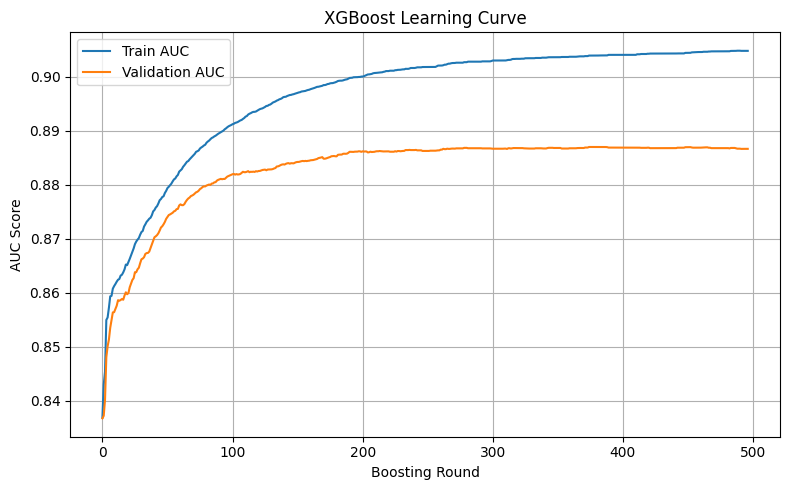

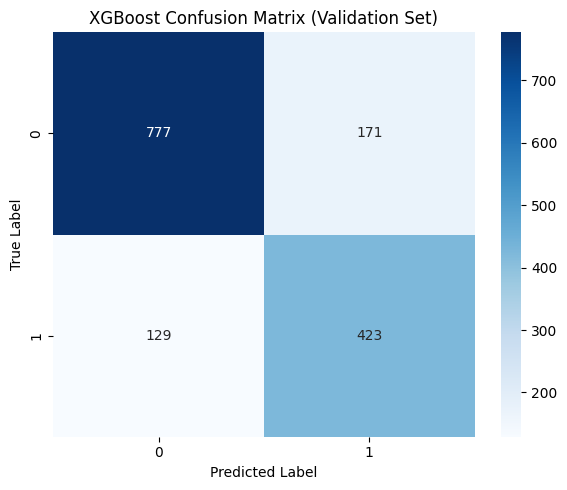

<Figure size 1000x600 with 0 Axes>

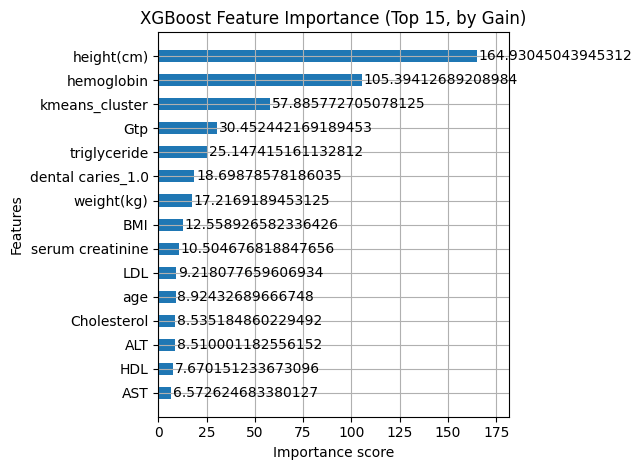

 98%|===================| 1476/1500 [00:25<00:00]        

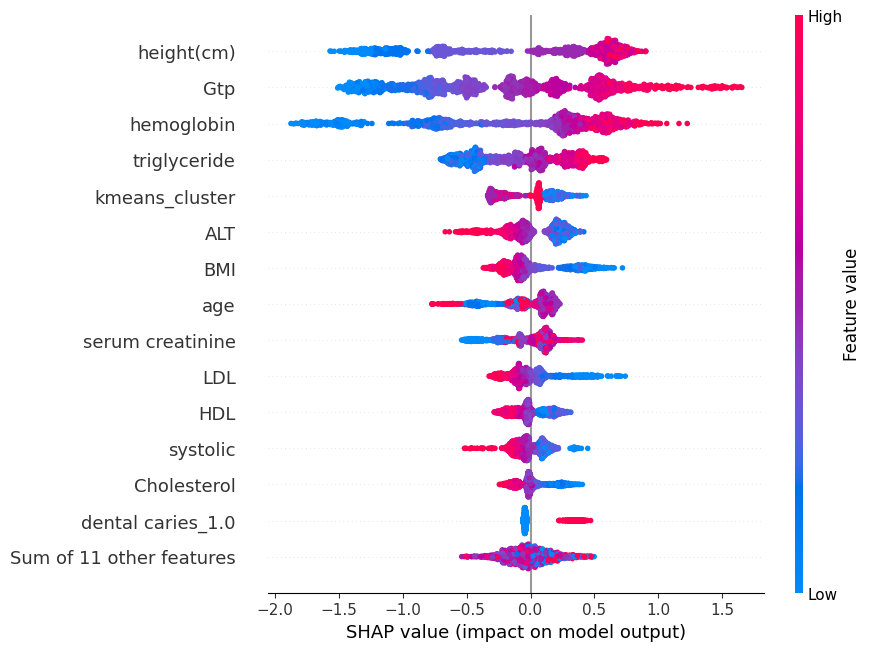

In [28]:
import optuna
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#-----------------------------
# 1. Define Optuna objective function
#-----------------------------
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'tree_method': 'hist',
        'grow_policy': 'lossguide',
        'device': 'cuda',
        'eval_metric': 'auc'
    }
    
    aucs = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    for train_idx, val_idx in skf.split(X, y):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_fold_train, 
            y_fold_train, 
            eval_set=[(X_fold_val, y_fold_val)],
            verbose=False
        )
        
        preds = model.predict_proba(X_fold_val)[:, 1]
        aucs.append(roc_auc_score(y_fold_val, preds))
    
    mean_auc = np.mean(aucs)
    trial.set_user_attr("params", params)
    trial.set_user_attr("mean_auc", mean_auc)
    return mean_auc

#-----------------------------
# 2. Run Optuna optimization
#-----------------------------
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

print("Best XGBoost Parameters:")
print(study_xgb.best_params)
print(f"Best AUC: {study_xgb.best_value:.4f}")

#-----------------------------
# 3. Train final model using best parameters
#-----------------------------
best_xgb = xgb.XGBClassifier(
    **study_xgb.best_params,
    tree_method='hist',
    device='cuda',
    eval_metric='auc',
    use_label_encoder=False
)

best_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

#-----------------------------
# 4. Draw learning curve
#-----------------------------
results = best_xgb.evals_result()

plt.figure(figsize=(8, 5))
plt.plot(results['validation_0']['auc'], label='Train AUC')
plt.plot(results['validation_1']['auc'], label='Validation AUC')
plt.xlabel('Boosting Round')
plt.ylabel('AUC Score')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------
# 5. Predict on validation set & draw confusion matrix
#-----------------------------
xgb_preds = best_xgb.predict_proba(X_val)
xgb_labels = np.argmax(xgb_preds, axis=1)
cm = confusion_matrix(y_val, xgb_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

#-----------------------------
# 6. Feature Importance Plot
#-----------------------------
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_xgb, max_num_features=15, importance_type='gain', height=0.5)
plt.title("XGBoost Feature Importance (Top 15, by Gain)")
plt.tight_layout()
plt.show()

#-----------------------------
# 7. SHAP Analysis (Global Explanation)
#-----------------------------
explainer = shap.Explainer(best_xgb, X_train, feature_names=X_train.columns)
shap_values = explainer(X_val)

# SHAP Summary Plot
shap.plots.beeswarm(shap_values, max_display=15)

# (Optional) Individual force plot for first prediction
# shap.plots.force(shap_values[0])  # <- 可視化個別樣本，Jupyter 內建支援互動


### 5.2 LightGBM 模型優化與訓練

LightGBM 是一個高效、低記憶體佔用的梯度提升框架，使用基於直方圖的分割尋找策略，適合大型資料集。

[I 2025-04-14 13:41:19,429] A new study created in memory with name: no-name-ed668776-9e0d-4853-bd95-f9605c56c876


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[216]	valid_0's auc: 0.882946
Early stopping, best iteration is:
[216]	valid_0's auc: 0.882946
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[284]	valid_0's auc: 0.8839
Early stopping, best iteration is:
[284]	valid_0's auc: 0.8839
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:41:41,526] Trial 0 finished with value: 0.8844334961589273 and parameters: {'n_estimators': 494, 'learning_rate': 0.09879603501728931, 'num_leaves': 39, 'max_depth': 3, 'min_child_samples': 83, 'subsample': 0.6804405994963252, 'colsample_bytree': 0.6054899004567418, 'reg_alpha': 0.36022873144196943, 'reg_lambda': 0.092768103128677}. Best is trial 0 with value: 0.8844334961589273.


Early stopping, best iteration is:
[177]	valid_0's auc: 0.886454
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[203]	valid_0's auc: 0.883593
Did not meet early stopping. Best iteration is:
[203]	valid_0's auc: 0.883593
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.883136
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.883136
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:42:01,796] Trial 1 finished with value: 0.884221779956746 and parameters: {'n_estimators': 203, 'learning_rate': 0.06441993931072466, 'num_leaves': 27, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.7833641006253093, 'colsample_bytree': 0.6705107749063399, 'reg_alpha': 4.819266929431219, 'reg_lambda': 2.516353124420597}. Best is trial 0 with value: 0.8844334961589273.


Did not meet early stopping. Best iteration is:
[203]	valid_0's auc: 0.885936
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[274]	valid_0's auc: 0.88456
Did not meet early stopping. Best iteration is:
[274]	valid_0's auc: 0.88456
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[160]	valid_0's auc: 0.884396
Early stopping, best iteration is:
[160]	valid_0's auc: 0.884396
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:42:27,732] Trial 2 finished with value: 0.8851442836336408 and parameters: {'n_estimators': 287, 'learning_rate': 0.07027546864437051, 'num_leaves': 141, 'max_depth': 5, 'min_child_samples': 66, 'subsample': 0.9049479053540948, 'colsample_bytree': 0.6076611858302192, 'reg_alpha': 4.871866068774765, 'reg_lambda': 0.7689076862830319}. Best is trial 2 with value: 0.8851442836336408.


Early stopping, best iteration is:
[207]	valid_0's auc: 0.886476
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.883421
Early stopping, best iteration is:
[69]	valid_0's auc: 0.883421
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[80]	valid_0's auc: 0.882618
Early stopping, best iteration is:
[80]	valid_0's auc: 0.882618
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:42:37,105] Trial 3 finished with value: 0.8836604798945707 and parameters: {'n_estimators': 488, 'learning_rate': 0.18968900071251862, 'num_leaves': 115, 'max_depth': 5, 'min_child_samples': 82, 'subsample': 0.6096210440916437, 'colsample_bytree': 0.8013395000735374, 'reg_alpha': 1.1583835496694688, 'reg_lambda': 1.5246747745487972}. Best is trial 2 with value: 0.8851442836336408.


Early stopping, best iteration is:
[54]	valid_0's auc: 0.884943
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.880776
Early stopping, best iteration is:
[61]	valid_0's auc: 0.880776
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's auc: 0.882281
Early stopping, best iteration is:
[59]	valid_0's auc: 0.882281
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:42:47,854] Trial 4 finished with value: 0.8827192907983251 and parameters: {'n_estimators': 315, 'learning_rate': 0.15575348871342054, 'num_leaves': 83, 'max_depth': 6, 'min_child_samples': 66, 'subsample': 0.9232947165704462, 'colsample_bytree': 0.916621781195837, 'reg_alpha': 2.628011177502771, 'reg_lambda': 1.4842155513507416}. Best is trial 2 with value: 0.8851442836336408.


Early stopping, best iteration is:
[76]	valid_0's auc: 0.885101
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[132]	valid_0's auc: 0.883242
Early stopping, best iteration is:
[132]	valid_0's auc: 0.883242
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[132]	valid_0's auc: 0.885623
Early stopping, best iteration is:
[132]	valid_0's auc: 0.885623
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:43:00,818] Trial 5 finished with value: 0.8850818161882748 and parameters: {'n_estimators': 325, 'learning_rate': 0.18081541094659997, 'num_leaves': 100, 'max_depth': 4, 'min_child_samples': 42, 'subsample': 0.8525173372077433, 'colsample_bytree': 0.6524757965516054, 'reg_alpha': 2.5290714473959417, 'reg_lambda': 2.4872699702645455}. Best is trial 2 with value: 0.8851442836336408.


Early stopping, best iteration is:
[73]	valid_0's auc: 0.886381
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.882238
Early stopping, best iteration is:
[68]	valid_0's auc: 0.882238
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.882437
Early stopping, best iteration is:
[56]	valid_0's auc: 0.882437
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:43:12,325] Trial 6 finished with value: 0.8833273479913858 and parameters: {'n_estimators': 420, 'learning_rate': 0.15408194193078145, 'num_leaves': 139, 'max_depth': 5, 'min_child_samples': 33, 'subsample': 0.8582208667804734, 'colsample_bytree': 0.9273110248303457, 'reg_alpha': 1.9652057777033893, 'reg_lambda': 0.23482708687457277}. Best is trial 2 with value: 0.8851442836336408.


Early stopping, best iteration is:
[76]	valid_0's auc: 0.885307
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.881482
Early stopping, best iteration is:
[49]	valid_0's auc: 0.881482
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.882199
Early stopping, best iteration is:
[65]	valid_0's auc: 0.882199
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:43:33,888] Trial 7 finished with value: 0.8819049562608647 and parameters: {'n_estimators': 390, 'learning_rate': 0.12899675090297608, 'num_leaves': 108, 'max_depth': 10, 'min_child_samples': 55, 'subsample': 0.8561641478479691, 'colsample_bytree': 0.6392804386981288, 'reg_alpha': 1.4478348595658845, 'reg_lambda': 3.079405528490091}. Best is trial 2 with value: 0.8851442836336408.


Early stopping, best iteration is:
[81]	valid_0's auc: 0.882033
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[206]	valid_0's auc: 0.882686
Early stopping, best iteration is:
[206]	valid_0's auc: 0.882686
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[213]	valid_0's auc: 0.883772
Early stopping, best iteration is:
[213]	valid_0's auc: 0.883772
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[227]	valid_0's auc: 0.887294
Early stopping, best iteration is:
[227]	valid_0's auc: 0.887294


[I 2025-04-14 13:44:07,462] Trial 8 finished with value: 0.8845841517196096 and parameters: {'n_estimators': 474, 'learning_rate': 0.04734316178901637, 'num_leaves': 43, 'max_depth': 6, 'min_child_samples': 84, 'subsample': 0.7587307541153273, 'colsample_bytree': 0.6494527345197337, 'reg_alpha': 0.34763872017104736, 'reg_lambda': 0.9935895484902857}. Best is trial 2 with value: 0.8851442836336408.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.881219
Early stopping, best iteration is:
[42]	valid_0's auc: 0.881219
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.879532
Early stopping, best iteration is:
[65]	valid_0's auc: 0.879532
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:44:33,381] Trial 9 finished with value: 0.8817699119072863 and parameters: {'n_estimators': 207, 'learning_rate': 0.15115746749598608, 'num_leaves': 76, 'max_depth': 10, 'min_child_samples': 99, 'subsample': 0.6368901256431744, 'colsample_bytree': 0.8322752022346562, 'reg_alpha': 1.0593651046986468, 'reg_lambda': 1.4690714905749802}. Best is trial 2 with value: 0.8851442836336408.


Early stopping, best iteration is:
[47]	valid_0's auc: 0.884559
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[280]	valid_0's auc: 0.88049
Did not meet early stopping. Best iteration is:
[280]	valid_0's auc: 0.88049
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[280]	valid_0's auc: 0.881561
Did not meet early stopping. Best iteration is:
[280]	valid_0's auc: 0.881561
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[280]	valid_0's auc: 0.883893
Did not meet early stopping. Best iteration is:
[280]	valid_0's auc: 0.883893


[I 2025-04-14 13:46:08,008] Trial 10 finished with value: 0.8819814815018763 and parameters: {'n_estimators': 280, 'learning_rate': 0.018368192995624914, 'num_leaves': 149, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.9980427118444428, 'colsample_bytree': 0.7457094534334938, 'reg_alpha': 4.935699485722396, 'reg_lambda': 4.425795769825472}. Best is trial 2 with value: 0.8851442836336408.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[273]	valid_0's auc: 0.883407
Did not meet early stopping. Best iteration is:
[273]	valid_0's auc: 0.883407
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[273]	valid_0's auc: 0.883565
Did not meet early stopping. Best iteration is:
[273]	valid_0's auc: 0.883565
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[240]	valid_0's auc: 0.886354
Early stopping, best iteration is:
[240]	valid_0's auc: 0.886354


[I 2025-04-14 13:46:41,999] Trial 11 finished with value: 0.884441969404505 and parameters: {'n_estimators': 275, 'learning_rate': 0.08741572422895824, 'num_leaves': 117, 'max_depth': 3, 'min_child_samples': 43, 'subsample': 0.8889598893092373, 'colsample_bytree': 0.7220244905033976, 'reg_alpha': 3.3863105610243167, 'reg_lambda': 3.792137812674973}. Best is trial 2 with value: 0.8851442836336408.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.881966
Early stopping, best iteration is:
[57]	valid_0's auc: 0.881966
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.882429
Early stopping, best iteration is:
[34]	valid_0's auc: 0.882429
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.883642
Early stopping, best iteration is:
[63]	valid_0's auc: 0.883642


[I 2025-04-14 13:47:10,294] Trial 12 finished with value: 0.8826792979027237 and parameters: {'n_estimators': 341, 'learning_rate': 0.18707758665147792, 'num_leaves': 64, 'max_depth': 8, 'min_child_samples': 61, 'subsample': 0.9516621122432983, 'colsample_bytree': 0.7178169460927137, 'reg_alpha': 3.6106989822225444, 'reg_lambda': 2.5728494568810185}. Best is trial 2 with value: 0.8851442836336408.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[265]	valid_0's auc: 0.883655
Did not meet early stopping. Best iteration is:
[265]	valid_0's auc: 0.883655
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[267]	valid_0's auc: 0.884577
Did not meet early stopping. Best iteration is:
[267]	valid_0's auc: 0.884577
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[262]	valid_0's auc: 0.887001
Did not meet early stopping. Best iteration is:
[262]	valid_0's auc: 0.887001


[I 2025-04-14 13:47:54,259] Trial 13 finished with value: 0.8850778518270084 and parameters: {'n_estimators': 268, 'learning_rate': 0.06631414733013596, 'num_leaves': 130, 'max_depth': 4, 'min_child_samples': 38, 'subsample': 0.8219436567905374, 'colsample_bytree': 0.6027990277558408, 'reg_alpha': 4.0131102117950075, 'reg_lambda': 4.928861642321104}. Best is trial 2 with value: 0.8851442836336408.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[93]	valid_0's auc: 0.882394
Early stopping, best iteration is:
[93]	valid_0's auc: 0.882394
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[92]	valid_0's auc: 0.882741
Early stopping, best iteration is:
[92]	valid_0's auc: 0.882741
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:48:27,107] Trial 14 finished with value: 0.8836976887819565 and parameters: {'n_estimators': 377, 'learning_rate': 0.1182120793797924, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 66, 'subsample': 0.7034824826286299, 'colsample_bytree': 0.6884749154506578, 'reg_alpha': 2.73303124518176, 'reg_lambda': 3.5012645125508515}. Best is trial 2 with value: 0.8851442836336408.


Early stopping, best iteration is:
[82]	valid_0's auc: 0.885958
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[319]	valid_0's auc: 0.878179
Did not meet early stopping. Best iteration is:
[319]	valid_0's auc: 0.878179
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[317]	valid_0's auc: 0.880172
Did not meet early stopping. Best iteration is:
[317]	valid_0's auc: 0.880172
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[318]	valid_0's auc: 0.883496
Did not meet early stopping. Best iteration is:
[318]	valid_0's auc: 0.883496


[I 2025-04-14 13:49:30,102] Trial 15 finished with value: 0.8806152918140379 and parameters: {'n_estimators': 319, 'learning_rate': 0.01593238916005682, 'num_leaves': 99, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.9636019064962358, 'colsample_bytree': 0.859427420884911, 'reg_alpha': 4.288840160604118, 'reg_lambda': 0.8686465876389777}. Best is trial 2 with value: 0.8851442836336408.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[245]	valid_0's auc: 0.881049
Did not meet early stopping. Best iteration is:
[245]	valid_0's auc: 0.881049
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[245]	valid_0's auc: 0.881843
Did not meet early stopping. Best iteration is:
[245]	valid_0's auc: 0.881843
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[227]	valid_0's auc: 0.885744
Did not meet early stopping. Best iteration is:
[227]	valid_0's auc: 0.885744


[I 2025-04-14 13:50:07,748] Trial 16 finished with value: 0.8828789854191391 and parameters: {'n_estimators': 245, 'learning_rate': 0.040759280506803997, 'num_leaves': 126, 'max_depth': 4, 'min_child_samples': 49, 'subsample': 0.8980057866644104, 'colsample_bytree': 0.9855693368342909, 'reg_alpha': 3.174108716420112, 'reg_lambda': 2.0375849048976606}. Best is trial 2 with value: 0.8851442836336408.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[187]	valid_0's auc: 0.882956
Early stopping, best iteration is:
[187]	valid_0's auc: 0.882956
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[137]	valid_0's auc: 0.88281
Early stopping, best iteration is:
[137]	valid_0's auc: 0.88281
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[96]	valid_0's auc: 0.884617
Early stopping, best iteration is:
[96]	valid_0's auc: 0.884617


[I 2025-04-14 13:50:53,967] Trial 17 finished with value: 0.8834605825693104 and parameters: {'n_estimators': 312, 'learning_rate': 0.08135667296402317, 'num_leaves': 64, 'max_depth': 7, 'min_child_samples': 71, 'subsample': 0.8191881205030226, 'colsample_bytree': 0.7737050502081645, 'reg_alpha': 1.7864556713441542, 'reg_lambda': 0.7244686771132076}. Best is trial 2 with value: 0.8851442836336408.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[258]	valid_0's auc: 0.883832
Early stopping, best iteration is:
[258]	valid_0's auc: 0.883832
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[215]	valid_0's auc: 0.884382
Early stopping, best iteration is:
[215]	valid_0's auc: 0.884382
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[169]	valid_0's auc: 0.886635
Early stopping, best iteration is:
[169]	valid_0's auc: 0.886635


[I 2025-04-14 13:51:30,529] Trial 18 finished with value: 0.8849495228909207 and parameters: {'n_estimators': 362, 'learning_rate': 0.12587499161813195, 'num_leaves': 150, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.7473259277414519, 'colsample_bytree': 0.6856874424964687, 'reg_alpha': 4.187908913963106, 'reg_lambda': 2.1613385791655446}. Best is trial 2 with value: 0.8851442836336408.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[114]	valid_0's auc: 0.880879
Early stopping, best iteration is:
[114]	valid_0's auc: 0.880879
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.882393
Early stopping, best iteration is:
[66]	valid_0's auc: 0.882393
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:51:52,127] Trial 19 finished with value: 0.8824093100762086 and parameters: {'n_estimators': 430, 'learning_rate': 0.17198897273932123, 'num_leaves': 96, 'max_depth': 5, 'min_child_samples': 51, 'subsample': 0.8669879147284812, 'colsample_bytree': 0.6251971305947761, 'reg_alpha': 2.1825743717349497, 'reg_lambda': 3.077672914749314}. Best is trial 2 with value: 0.8851442836336408.


Early stopping, best iteration is:
[45]	valid_0's auc: 0.883956
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[139]	valid_0's auc: 0.883764
Early stopping, best iteration is:
[139]	valid_0's auc: 0.883764
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[158]	valid_0's auc: 0.883583
Early stopping, best iteration is:
[158]	valid_0's auc: 0.883583
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:52:19,137] Trial 20 finished with value: 0.8840298968939498 and parameters: {'n_estimators': 251, 'learning_rate': 0.10971602066519753, 'num_leaves': 132, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.9321613902789453, 'colsample_bytree': 0.7533717462144587, 'reg_alpha': 3.034973913287235, 'reg_lambda': 3.9706416179314123}. Best is trial 2 with value: 0.8851442836336408.


Early stopping, best iteration is:
[83]	valid_0's auc: 0.884743
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[246]	valid_0's auc: 0.884508
Early stopping, best iteration is:
[246]	valid_0's auc: 0.884508
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[268]	valid_0's auc: 0.884673
Did not meet early stopping. Best iteration is:
[268]	valid_0's auc: 0.884673
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[196]	valid_0's auc: 0.887067
Early stopping, best iteration is:
[196]	valid_0's auc: 0.887067


[I 2025-04-14 13:53:06,047] Trial 21 finished with value: 0.8854160587794259 and parameters: {'n_estimators': 280, 'learning_rate': 0.06484533494949764, 'num_leaves': 125, 'max_depth': 5, 'min_child_samples': 39, 'subsample': 0.8154003745666811, 'colsample_bytree': 0.6166825286628619, 'reg_alpha': 4.0067589397046435, 'reg_lambda': 4.921633750968458}. Best is trial 21 with value: 0.8854160587794259.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[223]	valid_0's auc: 0.883651
Early stopping, best iteration is:
[223]	valid_0's auc: 0.883651
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[269]	valid_0's auc: 0.884155
Did not meet early stopping. Best iteration is:
[269]	valid_0's auc: 0.884155
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[298]	valid_0's auc: 0.887023
Did not meet early stopping. Best iteration is:
[298]	valid_0's auc: 0.887023


[I 2025-04-14 13:54:09,368] Trial 22 finished with value: 0.8849426184699315 and parameters: {'n_estimators': 298, 'learning_rate': 0.04447348377708438, 'num_leaves': 119, 'max_depth': 6, 'min_child_samples': 43, 'subsample': 0.8170461460954432, 'colsample_bytree': 0.6482362876426219, 'reg_alpha': 4.505293422491186, 'reg_lambda': 4.3999553204626345}. Best is trial 21 with value: 0.8854160587794259.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[248]	valid_0's auc: 0.883684
Early stopping, best iteration is:
[248]	valid_0's auc: 0.883684
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[176]	valid_0's auc: 0.884505
Early stopping, best iteration is:
[176]	valid_0's auc: 0.884505
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[214]	valid_0's auc: 0.886385
Early stopping, best iteration is:
[214]	valid_0's auc: 0.886385


[I 2025-04-14 13:54:54,493] Trial 23 finished with value: 0.884858163091943 and parameters: {'n_estimators': 340, 'learning_rate': 0.06603743103971951, 'num_leaves': 141, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.7886646508319163, 'colsample_bytree': 0.7020929087422327, 'reg_alpha': 3.5743124752977713, 'reg_lambda': 3.0851737138271274}. Best is trial 21 with value: 0.8854160587794259.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[218]	valid_0's auc: 0.883977
Early stopping, best iteration is:
[218]	valid_0's auc: 0.883977
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[232]	valid_0's auc: 0.883738
Did not meet early stopping. Best iteration is:
[232]	valid_0's auc: 0.883738
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[197]	valid_0's auc: 0.886428
Early stopping, best iteration is:
[197]	valid_0's auc: 0.886428


[I 2025-04-14 13:55:33,719] Trial 24 finished with value: 0.8847143359141701 and parameters: {'n_estimators': 250, 'learning_rate': 0.0862214161981493, 'num_leaves': 112, 'max_depth': 4, 'min_child_samples': 75, 'subsample': 0.8396908260092407, 'colsample_bytree': 0.6042148332272522, 'reg_alpha': 3.9185421021071463, 'reg_lambda': 2.0142568466507713}. Best is trial 21 with value: 0.8854160587794259.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[93]	valid_0's auc: 0.883818
Early stopping, best iteration is:
[93]	valid_0's auc: 0.883818
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.883138
Early stopping, best iteration is:
[52]	valid_0's auc: 0.883138
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:56:01,039] Trial 25 finished with value: 0.8845598695277851 and parameters: {'n_estimators': 293, 'learning_rate': 0.13836186894286065, 'num_leaves': 92, 'max_depth': 6, 'min_child_samples': 57, 'subsample': 0.8971036464280661, 'colsample_bytree': 0.6595333707128488, 'reg_alpha': 4.606450509911677, 'reg_lambda': 4.917400543438291}. Best is trial 21 with value: 0.8854160587794259.


Early stopping, best iteration is:
[92]	valid_0's auc: 0.886724
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[108]	valid_0's auc: 0.882643
Early stopping, best iteration is:
[108]	valid_0's auc: 0.882643
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[94]	valid_0's auc: 0.88489
Early stopping, best iteration is:
[94]	valid_0's auc: 0.88489
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 13:56:24,040] Trial 26 finished with value: 0.8846572630566163 and parameters: {'n_estimators': 224, 'learning_rate': 0.19999873626259557, 'num_leaves': 126, 'max_depth': 3, 'min_child_samples': 44, 'subsample': 0.7500370538585724, 'colsample_bytree': 0.6256066080652877, 'reg_alpha': 3.8308603319767203, 'reg_lambda': 2.7536681804366254}. Best is trial 21 with value: 0.8854160587794259.


Early stopping, best iteration is:
[139]	valid_0's auc: 0.886439
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[332]	valid_0's auc: 0.882854
Did not meet early stopping. Best iteration is:
[332]	valid_0's auc: 0.882854
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[323]	valid_0's auc: 0.883383
Did not meet early stopping. Best iteration is:
[323]	valid_0's auc: 0.883383
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[323]	valid_0's auc: 0.886246
Did not meet early stopping. Best iteration is:
[323]	valid_0's auc: 0.886246


[I 2025-04-14 13:57:55,353] Trial 27 finished with value: 0.8841609476316719 and parameters: {'n_estimators': 332, 'learning_rate': 0.026098159119392866, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 34, 'subsample': 0.9909389578650006, 'colsample_bytree': 0.6677426583079933, 'reg_alpha': 4.996832699746255, 'reg_lambda': 3.462570130253795}. Best is trial 21 with value: 0.8854160587794259.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[155]	valid_0's auc: 0.883701
Early stopping, best iteration is:
[155]	valid_0's auc: 0.883701
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[123]	valid_0's auc: 0.884482
Early stopping, best iteration is:
[123]	valid_0's auc: 0.884482
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[112]	valid_0's auc: 0.884719
Early stopping, best iteration is:
[112]	valid_0's auc: 0.884719


[I 2025-04-14 13:58:29,155] Trial 28 finished with value: 0.8843008235110448 and parameters: {'n_estimators': 362, 'learning_rate': 0.10053911628727534, 'num_leaves': 137, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7163144802975437, 'colsample_bytree': 0.6239012240464716, 'reg_alpha': 2.309237871239136, 'reg_lambda': 0.608307976853391}. Best is trial 21 with value: 0.8854160587794259.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[268]	valid_0's auc: 0.882951
Did not meet early stopping. Best iteration is:
[268]	valid_0's auc: 0.882951
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[194]	valid_0's auc: 0.882152
Early stopping, best iteration is:
[194]	valid_0's auc: 0.882152
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[252]	valid_0's auc: 0.886612
Early stopping, best iteration is:
[252]	valid_0's auc: 0.886612


[I 2025-04-14 13:59:10,250] Trial 29 finished with value: 0.883905289474994 and parameters: {'n_estimators': 297, 'learning_rate': 0.07478594200403393, 'num_leaves': 80, 'max_depth': 3, 'min_child_samples': 95, 'subsample': 0.8784189575999565, 'colsample_bytree': 0.6026782961089335, 'reg_alpha': 0.08518037987119165, 'reg_lambda': 0.33755120305562514}. Best is trial 21 with value: 0.8854160587794259.


Best LightGBM Parameters:
{'n_estimators': 280, 'learning_rate': 0.06484533494949764, 'num_leaves': 125, 'max_depth': 5, 'min_child_samples': 39, 'subsample': 0.8154003745666811, 'colsample_bytree': 0.6166825286628619, 'reg_alpha': 4.0067589397046435, 'reg_lambda': 4.921633750968458}
Best AUC: 0.8854
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[280]	training's auc: 0.927678	training's binary_logloss: 0.339414	valid_1's auc: 0.888883	valid_1's binary_logloss: 0.395834
Did not meet early stopping. Best iteration is:
[280]	training's auc: 0.927678	training's binary_logloss: 0.339414	valid_1's auc: 0.888883	valid_1's binary_logloss: 0.395834


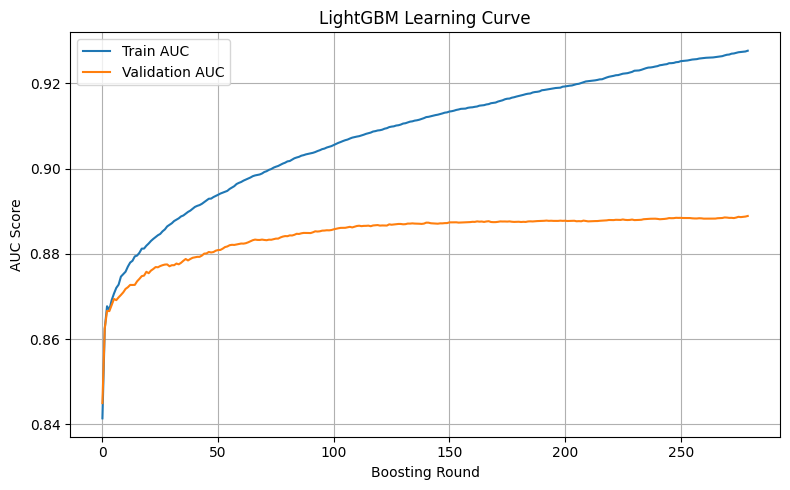

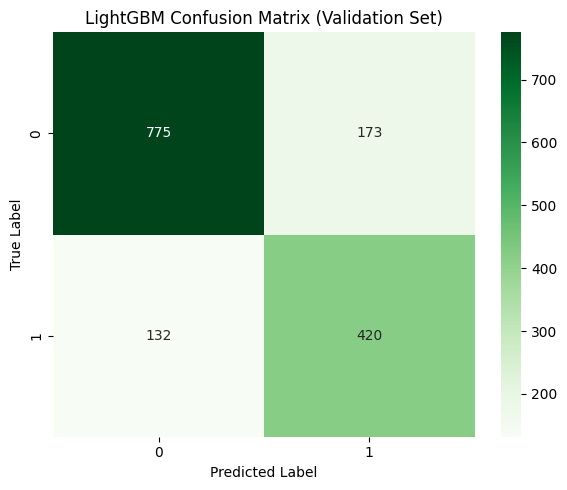

<Figure size 1000x600 with 0 Axes>

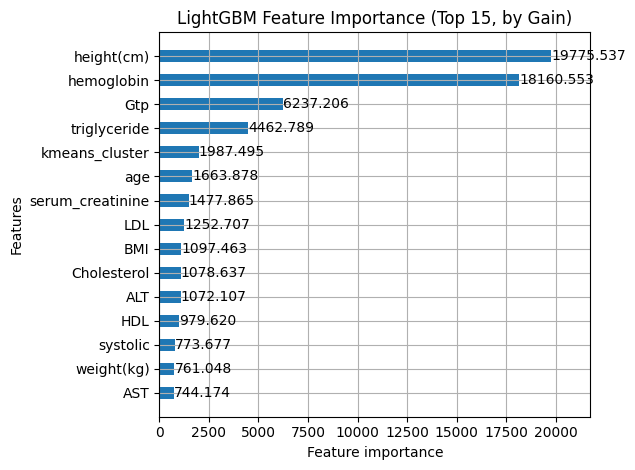

100%|===================| 1493/1500 [01:05<00:00]        

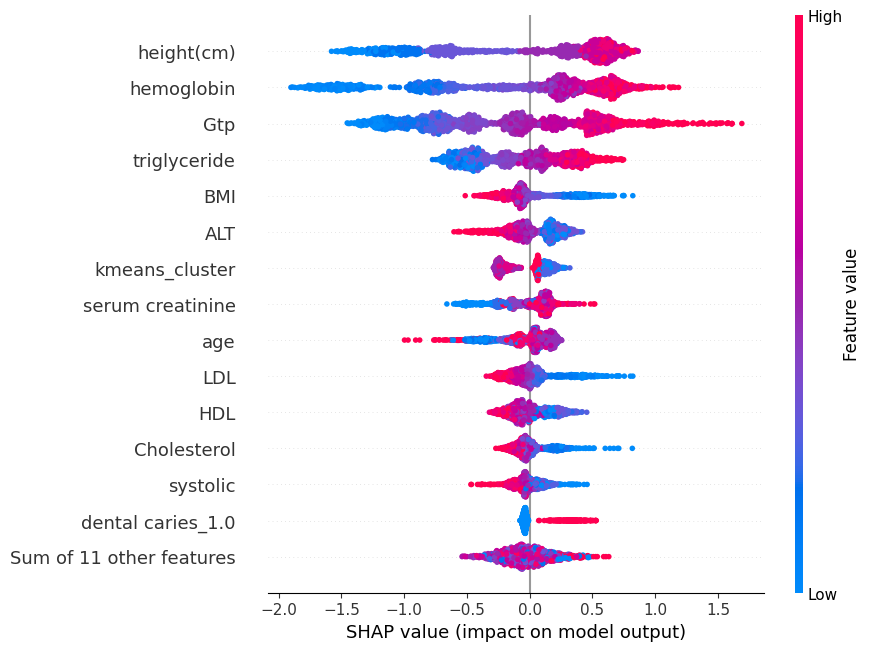

In [29]:
import optuna
import numpy as np
from lightgbm import LGBMClassifier
import lightgbm as lgb
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#-----------------------------
# 1. Define Optuna Objective Function
#-----------------------------
def objective_lgb(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'device_type': 'gpu',
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0)
    }

    aucs = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X, y):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        model = LGBMClassifier(**params)
        model.fit(
            X_fold_train,
            y_fold_train,
            eval_set=[(X_fold_val, y_fold_val)],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(30)]
        )

        preds = model.predict_proba(X_fold_val)[:, 1]
        aucs.append(roc_auc_score(y_fold_val, preds))

    mean_auc = np.mean(aucs)
    trial.set_user_attr("params", params)
    trial.set_user_attr("mean_auc", mean_auc)
    return mean_auc

#-----------------------------
# 2. Run Optuna Optimization
#-----------------------------
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)

print("Best LightGBM Parameters:")
print(study_lgb.best_params)
print(f"Best AUC: {study_lgb.best_value:.4f}")

#-----------------------------
# 3. Train Final Model with Best Parameters
#-----------------------------
best_lgb = LGBMClassifier(
    **study_lgb.best_params,
    verbosity=-1,
    device_type='gpu'
)

best_lgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(30)]
)

#-----------------------------
# 4. Draw Learning Curve
#-----------------------------
results = best_lgb.evals_result_

plt.figure(figsize=(8, 5))
plt.plot(results['training']['auc'], label='Train AUC')
plt.plot(results['valid_1']['auc'], label='Validation AUC')
plt.xlabel('Boosting Round')
plt.ylabel('AUC Score')
plt.title('LightGBM Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------
# 5. Predict on Validation Set & Confusion Matrix
#-----------------------------
lgb_preds = best_lgb.predict_proba(X_val)
lgb_labels = (lgb_preds[:, 1] >= 0.5).astype(int)

cm = confusion_matrix(y_val, lgb_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LightGBM Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

#-----------------------------
# 6. Feature Importance
#-----------------------------
plt.figure(figsize=(10, 6))
lgb.plot_importance(best_lgb, max_num_features=15, importance_type='gain', height=0.5)
plt.title('LightGBM Feature Importance (Top 15, by Gain)')
plt.tight_layout()
plt.show()

#-----------------------------
# 7. SHAP Analysis
#-----------------------------
explainer = shap.Explainer(best_lgb, X_train, feature_names=X_train.columns)
shap_values = explainer(X_val)

# SHAP Summary Plot
shap.plots.beeswarm(shap_values, max_display=15)

# (Optional) Individual force plot
# shap.plots.force(shap_values[0])


### 5.3 CatBoost 模型優化與訓練

CatBoost 是一種高效能的梯度提升樹實現，尤其擅長處理類別型特徵，並自動處理缺失值。

In [ ]:
import optuna
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap

#-----------------------------
# 1. Define Optuna Objective Function
#-----------------------------
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'eval_metric': 'AUC',
        'random_seed': 42,
        'task_type': 'GPU',  # or 'GPU' if you have CUDA
        'od_type': 'Iter',
        'od_wait': 30,
        'verbose': 0
    }

    aucs = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X, y):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostClassifier(**params)
        model.fit(X_fold_train, y_fold_train,
                  eval_set=(X_fold_val, y_fold_val),
                  use_best_model=True,
                  verbose=False)

        preds = model.predict_proba(X_fold_val)[:, 1]
        auc = roc_auc_score(y_fold_val, preds)
        aucs.append(auc)

    mean_auc = np.mean(aucs)
    trial.set_user_attr("params", params)
    trial.set_user_attr("mean_auc", mean_auc)
    return mean_auc

#-----------------------------
# 2. Run Optuna Optimization
#-----------------------------
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=30)

print("Best CatBoost Parameters:")
print(study_cat.best_params)
print(f"Best AUC: {study_cat.best_value:.4f}")

#-----------------------------
# 3. Train Final Model with Best Parameters
#-----------------------------
best_cat = CatBoostClassifier(
    **study_cat.best_params,
    eval_metric='AUC',
    task_type='CPU',
    random_seed=42,
    use_best_model=True,
    verbose=False
)

best_cat.fit(X_train, y_train, eval_set=(X_val, y_val))



[I 2025-04-14 14:13:15,771] A new study created in memory with name: no-name-0494f44c-9470-4b72-ae34-0a28124436f7


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-04-14 14:13:25,112] Trial 0 finished with value: 0.8812288251090955 and parameters: {'iterations': 475, 'learning_rate': 0.11362359965721225, 'depth': 8, 'l2_leaf_reg': 2.8121723357638855, 'bagging_temperature': 0.671913321349426, 'border_count': 194}. Best is trial 0 with value: 0.8812288251090955.
[I 2025-04-14 14:13:25,112] Trial 0 finished with value: 0.8812288251090955 and parameters: {'iterations': 475, 'learning_rate': 0.11362359965721225, 'depth': 8, 'l2_leaf_reg': 2.8121723357638855, 'bagging_temperature': 0.671913321349426, 'border_count': 194}. Best is trial 0 with value: 0.8812288251090955.
Default metric period is 5 becau

Best CatBoost Parameters:
{'iterations': 443, 'learning_rate': 0.04816682898154746, 'depth': 6, 'l2_leaf_reg': 5.503922821224408, 'bagging_temperature': 0.24476804417436138, 'border_count': 177}
Best AUC: 0.8851


KeyError: 'AUC'

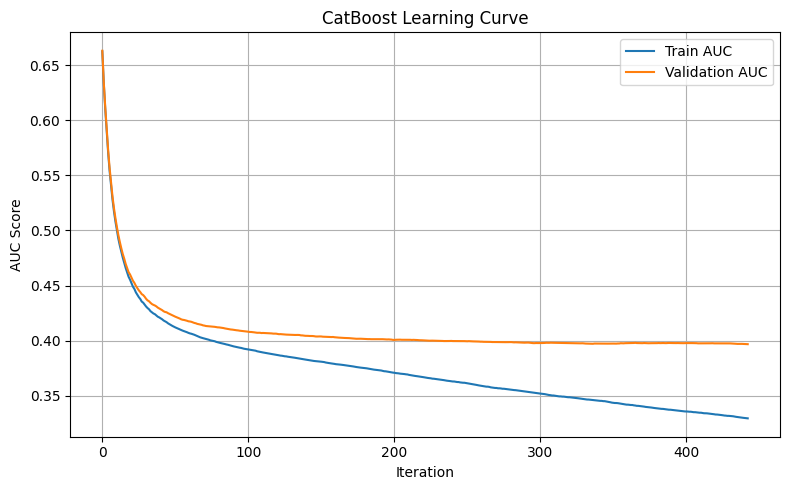

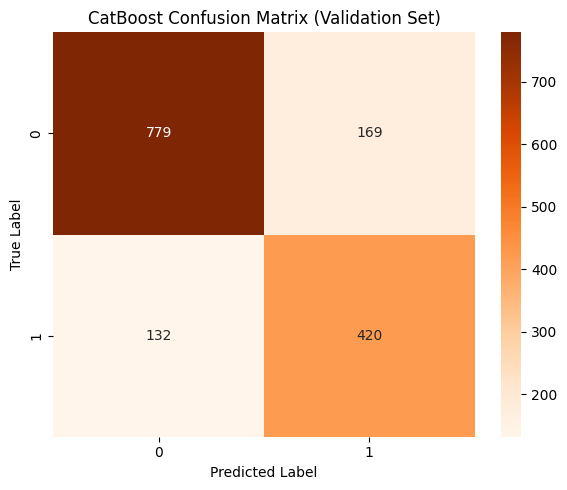

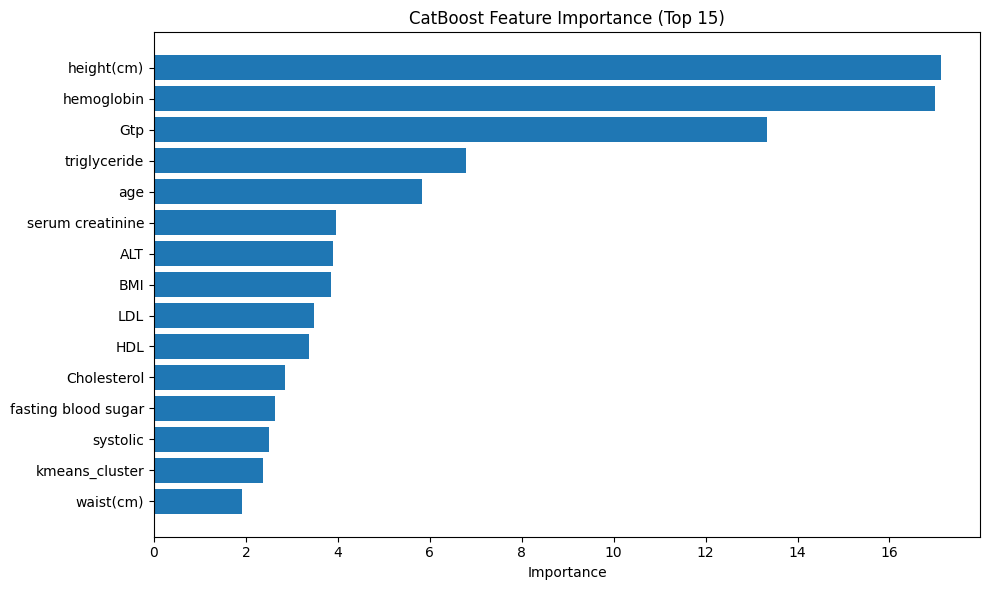

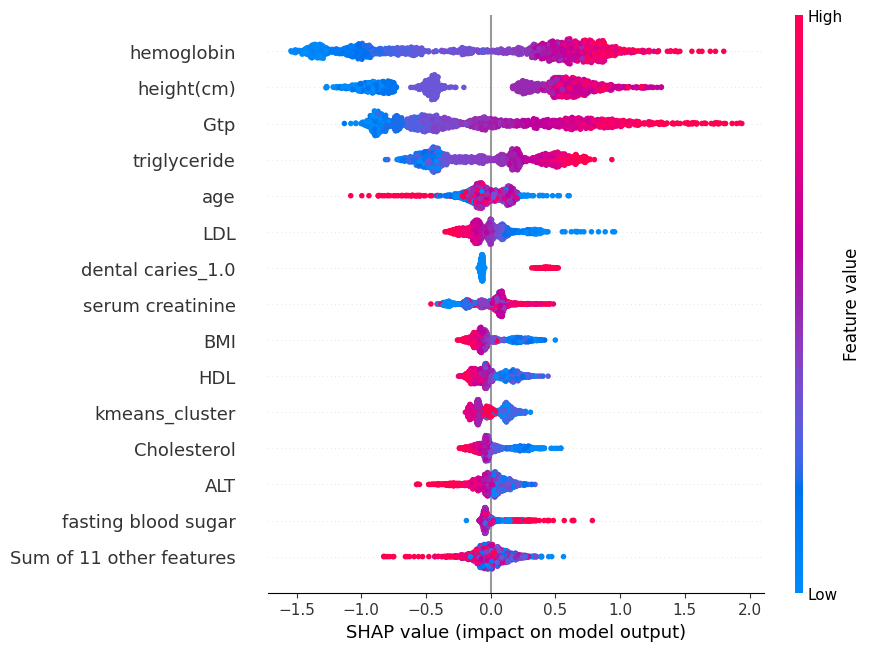

In [33]:
#-----------------------------
# 4. Draw Learning Curve
#-----------------------------
cat_log = best_cat.get_evals_result()
train_auc = cat_log['learn']['Logloss']
val_auc = cat_log['validation']['Logloss']

plt.figure(figsize=(8, 5))
plt.plot(train_auc, label='Train AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xlabel('Iteration')
plt.ylabel('AUC Score')
plt.title('CatBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------
# 5. Predict & Confusion Matrix
#-----------------------------
cat_preds = best_cat.predict_proba(X_val)[:, 1]
cat_labels = (cat_preds >= 0.5).astype(int)

cm = confusion_matrix(y_val, cat_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CatBoost Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

#-----------------------------
# 6. Feature Importance
#-----------------------------
plt.figure(figsize=(10, 6))
feat_importance = best_cat.get_feature_importance(prettified=True)
feat_importance_top = feat_importance.sort_values(by='Importances', ascending=False).head(15)

plt.barh(feat_importance_top['Feature Id'], feat_importance_top['Importances'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('CatBoost Feature Importance (Top 15)')
plt.tight_layout()
plt.show()

#-----------------------------
# 7. SHAP Summary Plot
#-----------------------------
explainer = shap.Explainer(best_cat)
shap_values = explainer(X_val)

# Summary plot
shap.plots.beeswarm(shap_values, max_display=15)

# (Optional) Individual force plot
# shap.plots.force(shap_values[0])


## 6. 模型集成與預測

在這部分，我們將根據各個模型在驗證集上的 AUC 表現，進行自動加權集成，結合三個模型的預測結果。

In [35]:
xgb_preds = best_xgb.predict_proba(X_test)
lgb_preds = best_lgb.predict_proba(X_test)
cat_preds = best_cat.predict_proba(X_test)

In [37]:
# 計算基於 AUC 的權重
auc_xgb = study_xgb.best_value or 0
auc_lgb = study_lgb.best_value or 0
auc_cat = study_cat.best_value or 0
total_auc = auc_xgb + auc_lgb + auc_cat
w_xgb = auc_xgb / total_auc
w_lgb = auc_lgb / total_auc
w_cat = auc_cat / total_auc

print(f"使用自動 AUC 權重：XGB = {w_xgb:.4f}, LGB = {w_lgb:.4f}, CAT = {w_cat:.4f}")

# 加權集成預測
final_preds = w_xgb * xgb_preds + w_lgb * lgb_preds + w_cat * cat_preds
#final_preds = xgb_preds 
#final_preds = lgb_preds 
#final_preds = cat_preds
# 生成提交檔案
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'submission_{timestamp}.csv'
sample_submission['smoking'] = final_preds
sample_submission.to_csv(filename, index=False)
print(f"提交檔案已儲存為 {filename}")

使用自動 AUC 權重：XGB = 0.3333, LGB = 0.3334, CAT = 0.3333
提交檔案已儲存為 submission_20250414_152835.csv
